# Portfolio Optimization by Shaping the Empirical Return Distribution

## Contents
1. Introduction
2. Mathematical problem statement
3. Implementation
4. Numerical example
5. Conclusion and directions for future work (scalability/parallel implementation)

## 1. Introduction
In this notebook, we present a portfolio optimization technique that seeks to maximize the expected return while accounting for a finite number of constraints related to limits of the value at risk (VaR) at one or several significance levels. We will show that this formulation makes it possible to view portfolio optimization as maximizing the mean of a distibution, that is linearly parametrized by the portfolio weights, subject to keeping the left/negative tail of the distribution below a user-defined distribution, which we will refer to as the _risk profile_. We will then bring this problem to into the form of a mixed-integer linear programming (MILP) problem and demonstrate its efficacy on a simple numerical example. Finally, we conclude and show some directions for future work.

## 2. Mathematical problem statement
Let $x \in \mathbb{R}^d, d \in \mathbb{N}$ denote a random variable describing the returns of $d$ assets. Let $D:=\{1,2,\dots,d\}$ and let $w\in W:=[0,1]^d$, such that $\sum_{i\in D} w_i = 1$, denote the weights of the assets in the portfolio. Then the (random) portfolio return is $\mathbb{E}[x]^\top w$, where $\mathbb{E}[\cdot]$ denotes the (element-wise) expectation operator associated with the distribution of each of the $d$ assets.

Since the exact expectation is unavailable in practice, we replace $\mathbb{E}[x]$ in the expression above by $\bar{x}\in \mathbb{R}^d$, which denotes the empirical mean return of $x$ from $n\in \mathbb{N}$ observations $x^{(n)}$, i.e. $\bar{x}_i = \frac{1}{n}\sum_n x_i^{(n)}$. Hence, our maximisation objective becomes 
\begin{equation}
\underset{w\in W}{\max}\bar{x}^\top w,
\end{equation}
which is linear in $w$. Let us now focus on the additional constraints that we seek to enforce. To this end, define two vector-valued parameters, $A\in [0,1]^k$ and $V\in\mathbb{R}^k$, where $k\in \mathbb{N}$. These are significance levels and corresponding values at risk. For example $A:=[0.01,0.05]$ and $V:=[-0.2,-0.1]$ would denote two VaR constraints, i.e. the 1% value at risk should be no smaller than -20% and the 5% value at risk should be no smaller than -10%. The constraints are then formulated, using an additional auxiliary variable $z^{(a)}\in [0,1]^n$ for all $a \in K:=\{1,2,\dots,k\}$, as

\begin{align}
\sum_{i\in N} z^{(a)}_i =& n A_a \text{, for all } a \in K,\\
x_i^\top w \geq& V_a - M(1-z^{(a)}_i) \text{, for all } (a,i) \in K\times N,
\end{align}

where $M\in \mathbb{R}_++$ is sufficiently large, such that the inequality is always satisfied when $z^{(a)}_i=1$, for all choices of $w\in W$. Hence, this reformulation is also known as the big $M$ method. The first equality constraint ensures that for any VaR condition $a\in K$, the number of $z^{(a)}_i=1$ equal the fraction of samples $n$, i.e. $z^{(a)}$ is a selector variable that ensures that sufficiently many constraints need to be satisfied, i.e. if $z^{(a)}_i =1$, then the weights $w$ must be chosen such that $x_i^\top w \geq V_a$. This ensures that the VaR constraint is satisfied. Combining the objective and the constraints, we are now ready to implement this problem in Python.

## 3. Imlementation
We use Pyhon and the $\texttt{mip}$ package (https://www.python-mip.com/) for mixed-integer linear programming and formulat the optimization routine by means of the following function:

In [34]:
def portfolioMILP(X, alpha=[0.05], VaR=[0], M = 2, max_weight=1, max_s = 10, abs_gap=1e-3):
    """
    Optimizes portfolio weights in a Mixed-Integer Linear Programming (MILP) setting, based on data X with n rows (observations)
    and d columns (assets), given a list (even if only a single value is desired!) of values at risk (VaR) at significance levels alpha, respectively. The variable
    "M" is used in a big M method trick to linearise the constraints. "max_weights" defines the maximum weight of an asset,
    "max_s" defines the maximum computation time, "abs_gap" defines the absolute gap between upper bound and lower bound on the solution,
    upon which the algorithm shall terminate.
    """
    
    n,d = X.shape
    X_mean = X.mean(axis=0)
    print(f"Optimizing over {d} assets using {n} samples")
    
    n_alpha = len(alpha)
    V=[[] for i in range(n_alpha)]
    
    m = Model(solver_name=CBC)
    m.max_mip_gap_abs = abs_gap
    
    w = [ m.add_var(var_type=CONTINUOUS) for dd in range(d) ] #decision variables (asset weights)
    m.objective = minimize(-xsum(w[dd]*X_mean[dd] for dd in range(d))) #objective function
    m += xsum(w[dd] for dd in range(d)) == 1 #asset weights sum to 1
    
    #VaR constraints
    for aa in range(n_alpha): #for all VaR constraints
        n_activeCon = np.ceil(n*(1-alpha[aa])) #number of constraints that need to be active at solution
        
        v = [] #indices of violation samples (samples for which a feasible w exists that would violate the VaR constraint)
        for i in range(n):
            if any(X[i,:] < VaR[aa]): #else, no weights w lead to a return of sample i to be less than the VaR
                v.append(i)
        n_v = len(v) 
        V[aa] = v #useful for visualising the solution

        z = [m.add_var(name=f"z_{aa}_{vv}",var_type=BINARY) for vv in range(n_v) ] #selector variable for active constraints
        m += xsum(m.var_by_name(f'z_{aa}_{vv}') for vv in range(n_v)) == max(0,n_activeCon - (n-n_v)) #n-n_v constraints always satisfied
        for vv in range(n_v):
            m += xsum(w[dd]*X[v[vv],dd] for dd in range(d)) >= (VaR[aa] - (1-m.var_by_name(f'z_{aa}_{vv}'))*M) #linearized VaR constraint using bigg M notation
    
    #weight constraints
    if type(max_weight) != list and max_weight != 1: 
        for dd in range(d):
            m += w[dd] <= max_weight
    else:
        for dd in range(d):
            m += w[dd] <= max_weight[dd]

    #obtain model summary
    m.write('model.lp')
    m.read('model.lp')
    print('The model has {} vars, {} constraints and {} nzs'.format(m.num_cols, m.num_rows, m.num_nz))

    # optimizing
    status = m.optimize(max_seconds = max_s)
    if status != OptimizationStatus.OPTIMAL:
        print(np.round(alpha,3), np.round(VaR,3), status) #if solution not optimal, print details
    return m,V

## 4. Numerical Example

We now consider a simple 2-dimensional example ($d=2$), where the two assets are the S&P 500 index ("gspc") and the gold price ("gold"). For the purpose of this simple example we ignore any other costs related to the investment or its liquidation (e.g. taxes). We use the following helper function to 
* extract the data from ".csv"-files,
* fill in missing values for days without trade (e.g. weekends),
* to select the common period for all assets
* and to store the results in a pandas data frame.

In [84]:
def loadData(files, days):
    """
    Reads csv "files", fills in missing dates and close prices, computes annualized returns over the number of "days" and returns a pandas 
    data frame.
    """
    years=days/365 #used to compute annualized returns
    dataFrames_in = []
    start_dates = [] 
    end_dates =[] #used to find greatest common trade period
    
    for file in files:
        df_in = pd.read_csv('C:/Users/worc3920/Documents/GitHub/EmpiricalPortfolio/data/'+file+'.csv', usecols=["Date","Close"]) #file path may depend on your project
        df_in = df_in.rename(columns={"Close": "Close_" + file})
        df_in["Date"]=pd.to_datetime(df_in["Date"], infer_datetime_format=True)
        dataFrames_in.append(df_in)
        start_dates.append(df_in.loc[0,"Date"])
        end_dates.append(df_in.loc[df_in.index[-1],"Date"])
    
    df_start = max(start_dates) #select latest common start date
    df_end = min(end_dates) #select earliest common end date, hence data available for all selected dates and assets
    df = pd.DataFrame()
    df["Date"] = pd.date_range(start=df_start, end=df_end)

    for i in range(len(files)):
        df = df.merge(dataFrames_in[i], on='Date', how='left') #combine data frames
    for file in files:
        #Ensure no NaN values at the beginning of the data set
        j=0
        while True:
            if np.isnan(df.loc[j,"Close_" + file]):
                j += 1
            else:
                df.loc[0:j-1,"Close_" + file] = df.loc[j,"Close_" + file]
                break
        #Replace NaN values by previous (valid) value
        for i in range(0,len(df)):
            if np.isnan(df.loc[i,"Close_" + file]):
                df.loc[i, "Close_" + file] = df.loc[i-1, "Close_"+file]
        
        #Compute return, assuming that negative final values will be replaced by 0
        for i in range(len(df)-days):
            df.loc[i, "Return_" + file] = (np.max([0,df.loc[i+days, "Close_"+file]])/df.loc[i, "Close_"+file])**(1/years)-1 #annual. return
    #drop last days entries, for which no return could be computed
    return df.drop(columns=["Close_" + file for file in files]).iloc[:-days-1]

Let us begin by loading all required packages and obtaining the data using the above helper function:

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import pandas as pd
import datetime
import warnings
from mip import *
import time

#read data and show summary
#files = ["gspc","gold","n225","hsi","oil"]
files = ["gspc","gold","hsi"]
days=15*365
df = loadData(files, days)
fileR = ["Return_"+file for file in files]

In [86]:
df["equal_split"]=(df[fileR].sum(axis=1))/len(files)
np.round(df.describe(),2)

,Return_gspc,Return_gold,Return_hsi,equal_split
count,6964.00,6964.00,6964.00,6964.00
mean,0.06,0.07,0.07,0.06
std,0.02,0.04,0.03,0.01
min,0.01,-0.03,0.00,0.03
25%,0.04,0.04,0.04,0.06
50%,0.06,0.08,0.06,0.07
75%,0.08,0.10,0.09,0.07
max,0.11,0.13,0.12,0.09


In [87]:
percentiles = [0.001,0.01]#,0.05]
n_df = len(df)
myVaR = np.sort(df["equal_split"].to_numpy())[[int(np.round(n_df*percentiles[i])) for i in range(len(percentiles))]]
print(np.array(percentiles)*100) #percentiles in percent
print(np.round(myVaR*100,2)) #VaR in percent

[0.1 1. ]
[3.27 3.64]


In [88]:
df[fileR].corr()

,Return_gspc,Return_gold,Return_hsi
Return_gspc,1.000000,-0.782166,0.847736
Return_gold,-0.782166,1.000000,-0.746408
Return_hsi,0.847736,-0.746408,1.000000


KeyError: None

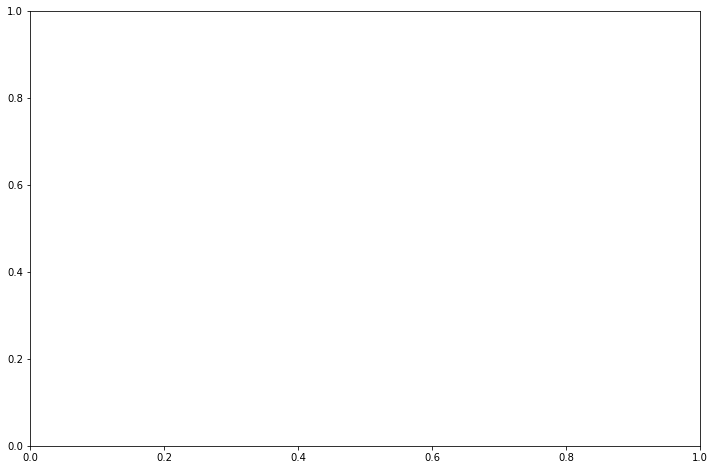

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df["Date"], df[fileR.append("equal_split")], linewidth=0.5)
ax.legend(fileR.append("equal_split"))
ax.set_ylim((-0.1,0.17))

Notice that an equal allocation to both assets would result in a mean between the means of the individual assets, but the standard error (std) is smaller.

In [89]:
X = df[fileR].to_numpy()

In [52]:
#Select data and VaR constraints

alpha = percentiles#[0.001, 0.01, 0.02]#[0.001, 0.01, 0.1]#[0.001, 0.01, 0.10]
VaR = myVaR+0.001 #[0.03, 0.035, 0.04]#[0.02, 0.03, 0.04]#[-0.05, -0.02, 0.01]

skip = 1 #to speed up the solution process, we only select every "skip"-th row for this example
m,V = portfolioMILP(X[::skip,:], alpha, VaR, max_s = 60, max_weight=0.6) #run MILP for at most max_s seconds

if m.status == OptimizationStatus.OPTIMAL or m.status == OptimizationStatus.FEASIBLE:
    wStar = [m.vars[i].x for i in range(np.shape(X)[1])] #optimal weights
    print(m.status)
    print("The optimal asset allocation is "+str(np.round(wStar,2)))
    print("Portfolio return: "+str(np.round(sum(wStar*X.mean(axis=0))*100,2))+" %")
    print("Portfolio std: "+str(np.round(np.std([sum(wStar*X[i,:]) for i in range(X.shape[0])])*100,2))+" %")

Optimizing over 3 assets using 6964 samples
The model has 7340 vars, 7343 constraints and 36683 nzs
OptimizationStatus.OPTIMAL
The optimal asset allocation is [0.42 0.33 0.25]
Portfolio return: 6.38 %
Portfolio std: 1.03 %


In [101]:
############TIME SERIES FUN STARTS HERE ###################
#VARIMA p,i,q where lags are shifted by the investment horizon

from statsmodels.tsa.statespace.varmax import VARMAX

def lagVARIMA(X=X, p=3, i=0, q=2, lag=int(days/365)):
    #difference data
    n,d=np.shape(X)
    
    #differencing updates X
    for dd in range(d):
        X[dd:-1,:] = X[dd+1:,:]-X[dd:-1,:]
        X=X[:-1,:]
    n -= d
    
    #build constraint dictionary
    con = dict()
    for l1 in range(1,lag+1):
        for d1 in range(1,dd+1):
            for d2 in range(1,d1+1):
                con[f'L{l1}.y{d1}.y{d2}'] = 0
                #con[f'L{l1}.e(y{d1}).y{d2}'] = 0
    
    #fit model
    model = VARMAX(X, order=(lag+p, 0), enforce_stationarity=False, enforce_invertibility=False, verbose=True,  initialization='approximate_diffuse' )
    res = model.fit_constrained(con)
    return res


In [ ]:
skip=1
res = lagVARIMA(X[::skip,:]-X.mean(axis=0), p=3, q=0)

In [ ]:
res.summary()

We can now visualize the result to see how the MILP algorithm has segmented the distribution according to the VaR constraints:

In [123]:
def plotDistribution(X, m, V, alpha, i0=0, i1=1, names=["SP500","HSI"], cmap_str = 'gist_rainbow', markersize=5, fig_size=(8,6)):
    x1=X[:,i0]
    x2=X[:,i1]
    
    n_x=len(x1)
    d=2
    n_alpha=len(alpha)
    dropped=[[] for i in range(n_alpha)]
    kept=list(range(n_x))

    for aa in range(n_alpha):
        for vv in range(len(V[aa])):
            if m.var_by_name(f'z_{aa}_{vv}').x == 0:
                dropped[aa].append(V[aa][vv])

    fig=plt.figure(figsize = fig_size, dpi = 100)
    cmap=plt.cm.get_cmap(cmap_str,n_alpha)
    
    plt.scatter(x1[kept],x2[kept],s=markersize,c='grey')
    for aa in reversed(range(n_alpha)):
        plt.scatter(x1[dropped[aa]],x2[dropped[aa]],s=markersize,color=cmap(aa/(n_alpha)))
    
    plt.grid(True)
    plt.xlabel(names[0])
    plt.ylabel(names[1])
    plt.title('Annual returns')

    plt.gca().set_aspect('equal', adjustable='box')
    return x1, x2, cmap

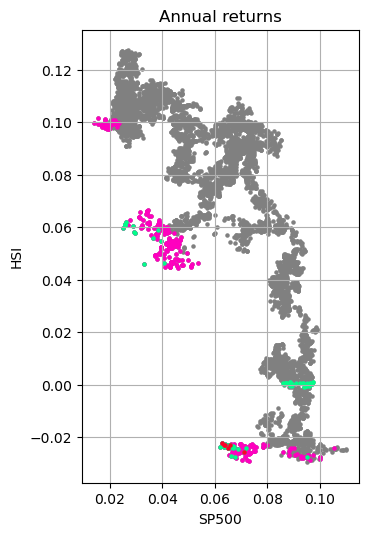

In [144]:
x1, x2, cmap = plotDistribution(X[::skip,:], m, V, alpha, markersize=5)

In [36]:
def getEmpiricalDensity(series):
    df2=pd.DataFrame()
    df2["value"]=series
    # Frequency
    stats_df = df2 \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    
    # Plot
    ax = stats_df.plot(x = 'value', y = 'cdf', #xlim=(-0.1,0.1), 
                       grid = True,legend=False)
    return ax

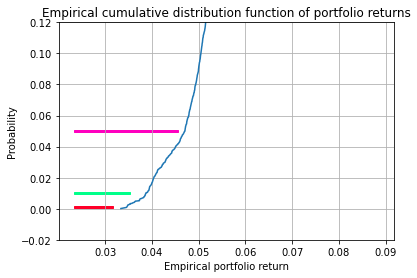

In [145]:
Xskip=X[::skip,:]
R = np.sort([sum(wStar*Xskip[i,:]) for i in range(len(Xskip))])
add_length=0.01
getEmpiricalDensity(pd.Series(R))
for i in range(len(VaR)):
    plt.arrow(x=np.min(R)-add_length, dx=VaR[i]-np.min(R)+add_length, y=alpha[i], dy=0, color=cmap(i/len(alpha)), length_includes_head = True,
                   head_width=0,head_length=0)
plt.xlabel('Empirical portfolio return')
plt.ylabel('Probability')
plt.title('Empirical cumulative distribution function of portfolio returns')

axes = plt.gca()
axes.set_ylim(-0.02,0.12)
plt.show()